In [1]:
# Install third-party PCA library (run once)
!pip install pca
!pip install plotly


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from pca import pca
from sympy import factor
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



In [3]:
# Load happiness dataset using relative path
df = pd.read_csv("../datasets/happy.csv")

# Quick check to see if import worked
df.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.632,1.305,1.592,0.874,0.681,0.202,0.393
1,2,Norway,7.594,1.456,1.582,0.861,0.686,0.286,0.340
2,3,Denmark,7.555,1.351,1.590,0.868,0.683,0.284,0.408
3,4,Iceland,7.495,1.343,1.644,0.914,0.677,0.353,0.138
4,5,Switzerland,7.487,1.420,1.549,0.927,0.660,0.256,0.357


[21-12-2025 00:56:52] [pca.pca] [INFO] Row labels are auto-completed.
[21-12-2025 00:56:52] [pca.pca] [INFO] PCA reduction performed to capture at least 95.0% explained variance using 6 columns of the input data.
[21-12-2025 00:56:52] [pca.pca] [INFO] Fit using PCA.
[21-12-2025 00:56:52] [pca.pca] [INFO] Compute loadings and PCs.
[21-12-2025 00:56:52] [pca.pca] [INFO] Compute explained variance.
[21-12-2025 00:56:52] [pca.pca] [INFO] The top 5 principal component(s) explains >= 95.00% of the explained variance.
[21-12-2025 00:56:52] [pca.pca] [INFO] The PCA reduction is performed on 6 variables (columns) of the input dataframe.
[21-12-2025 00:56:52] [pca.pca] [INFO] Fit using PCA.
[21-12-2025 00:56:52] [pca.pca] [INFO] Compute loadings and PCs.
[21-12-2025 00:56:52] [pca.pca] [INFO] Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[21-12-2025 00:56:52] [pca.pca] [INFO] Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[21-12-2025 00:56:52]

(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': 'The top 5 Principal Component(s) explains [97.43%] of the variance.'}, xlabel='PC1 (48.8% expl.var)', ylabel='PC2 (23.2% expl.var)'>)

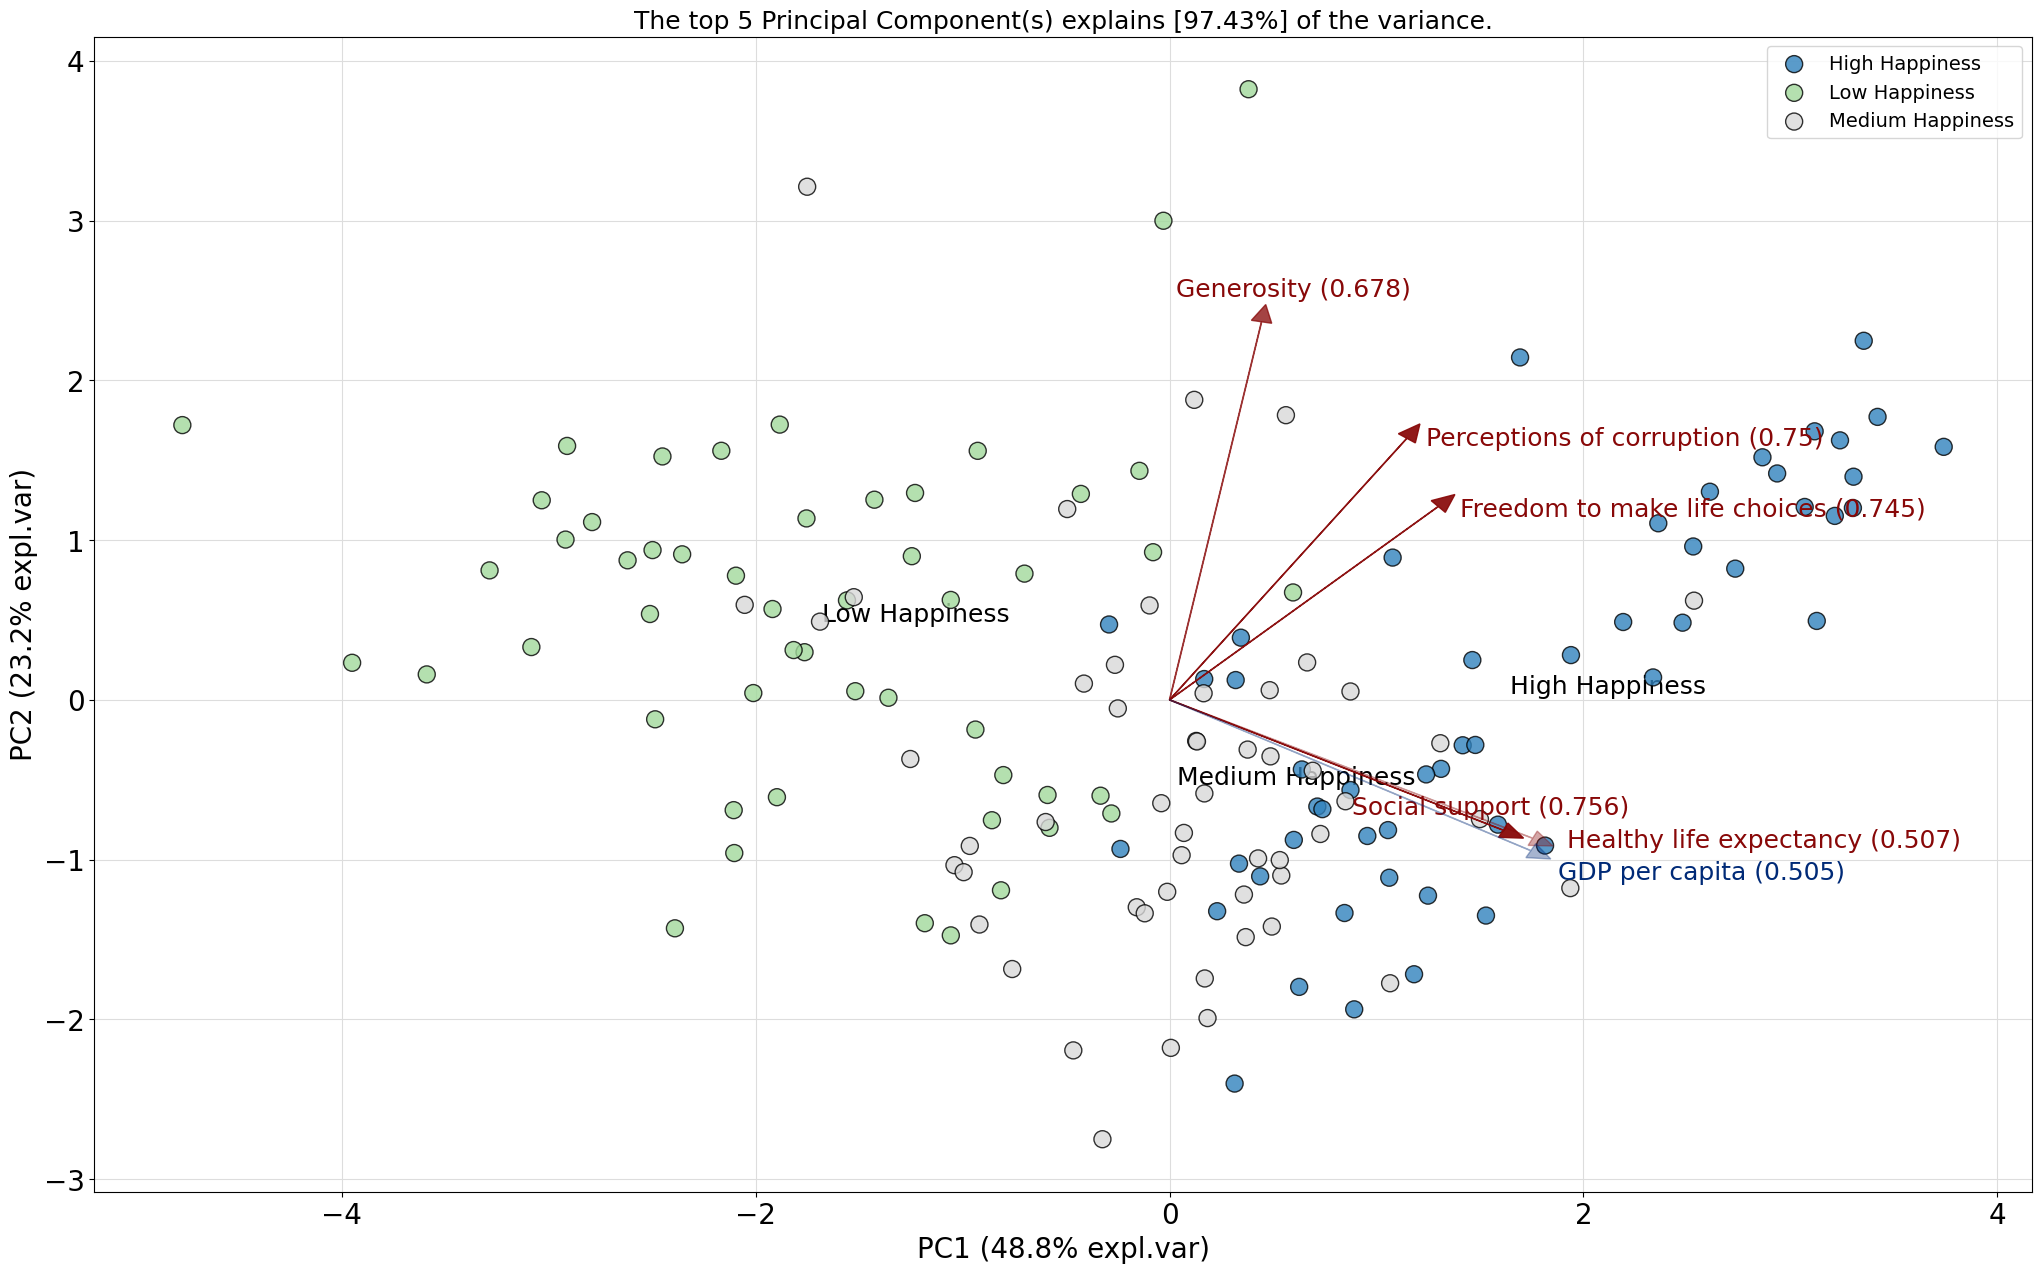

In [58]:
df1 = df.copy()
# This creates 3 groups: High, Medium, and Low happiness
y_categories = pd.qcut(df1["Score"], q=3, labels=["Low Happiness", "Medium Happiness", "High Happiness"])

# 2. Prepare X (excluding non-features)
X = df1.drop(columns=["Country or region", "Overall rank", "Score"], errors="ignore")
labels = X.columns

# 3. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Initialize and Fit
model = pca() 
results = model.fit_transform(X_scaled, col_labels=labels)

# 5. Biplot using the CATEGORIES for coloring
model.biplot(labels=y_categories, legend=True)

In [44]:
model.results['topfeat']

,PC,feature,loading,type
0,PC1,Score,0.480165,best
1,PC2,Generosity,0.681178,best
2,PC3,Freedom to make life choices,0.749529,best
3,PC4,Perceptions of corruption,0.759132,best
4,PC5,Social support,0.763793,best
5,PC1,GDP per capita,0.450115,weak
6,PC1,Healthy life expectancy,0.448479,weak


In [45]:
print(results['variance_ratio'])

[0.5365801  0.20066003 0.08530055 0.0846933  0.04720424 0.02564045
 0.01992132]


In [46]:
print(model.results['explained_var'])

[0.5365801  0.73724013 0.82254068 0.90723398 0.95443822 0.98007868
 1.        ]


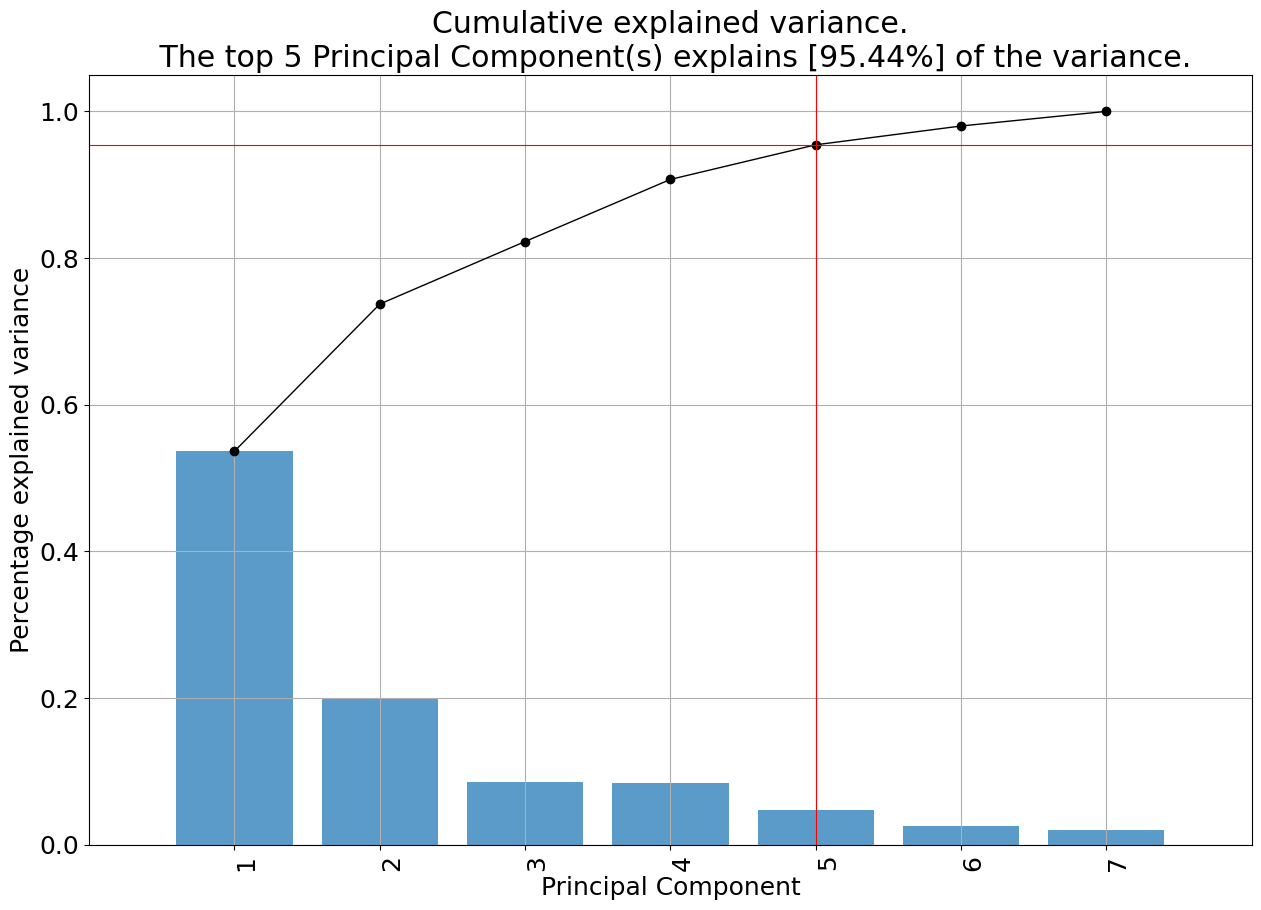

In [48]:
model.plot();

In [64]:
# 1. Run KMeans
pca_data = results['PC'].iloc[:, :2] 
kmeans = KMeans(n_clusters=3, random_state=42).fit(pca_data)

# 2. Map the numbers to names
# We create a dictionary to define which number corresponds to which label
cluster_map = {0: "Medium Happiness", 1: "Low Happiness", 2: "High Happiness"}

# 3. Apply the map to a new column
df1['Happiness_Level'] = kmeans.labels_
df1['Happiness_Level'] = df1['Happiness_Level'].map(cluster_map)

# 4. Plot using the new named column
fig = px.scatter(pca_data, x='PC1', y='PC2', 
                 color=df1['Happiness_Level'], # Use the names here
                 hover_name=df1['Country or region'],
                 color_discrete_map={
                     "High Happiness": "green",
                     "Medium Happiness": "orange",
                     "Low Happiness": "red"
                 },
                 title="World Happiness Clusters")

fig.show()

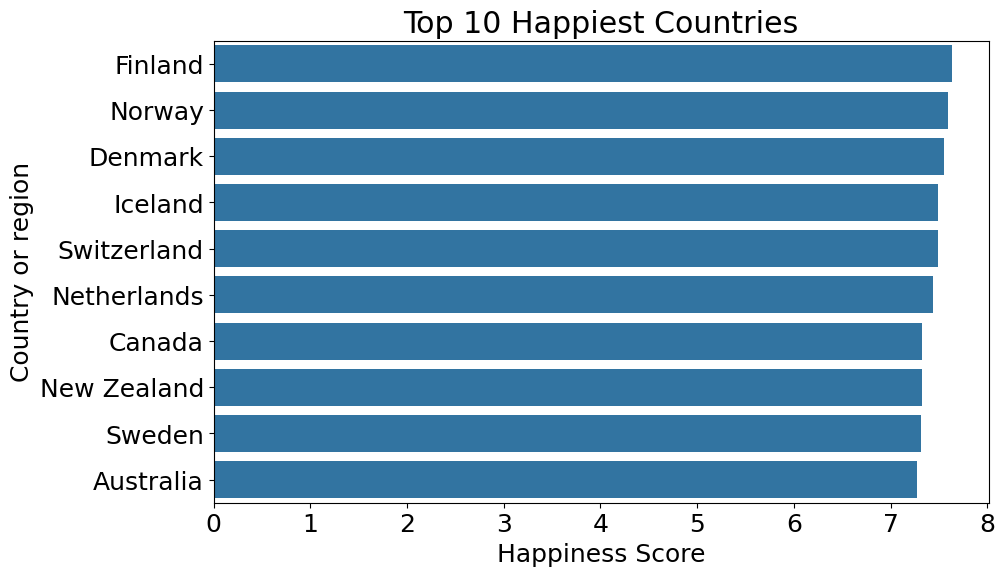

In [50]:
# Overall happiness score by country top 10
top_10 = df[['Country or region', 'Score']].sort_values(by='Score', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(data=top_10, x='Score', y='Country or region')
plt.title('Top 10 Happiest Countries')
plt.xlabel('Happiness Score')
plt.ylabel('Country or region')
plt.show()

In [63]:
import plotly.express as px

# 1. Create the map
fig = px.choropleth(df1, 
                    locations="Country or region", 
                    locationmode='country names',
                    color="Happiness_Level", # This is the column we mapped earlier
                    hover_name="Country or region",
                    # Optionally, add the raw score to the hover data
                    hover_data=["Score"],
                    title="Global Happiness Clusters (Based on PCA Analysis)",
                    color_discrete_map={
                        "High Happiness": "#00CC96",   # Green
                        "Medium Happiness": "#EF553B", # Orange
                        "Low Happiness": "#AB63FA"     # Purple
                    },
                    projection="natural earth") # A clean, modern map look

# 2. Update layout for a cleaner look
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_3280\573243424.py:4: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



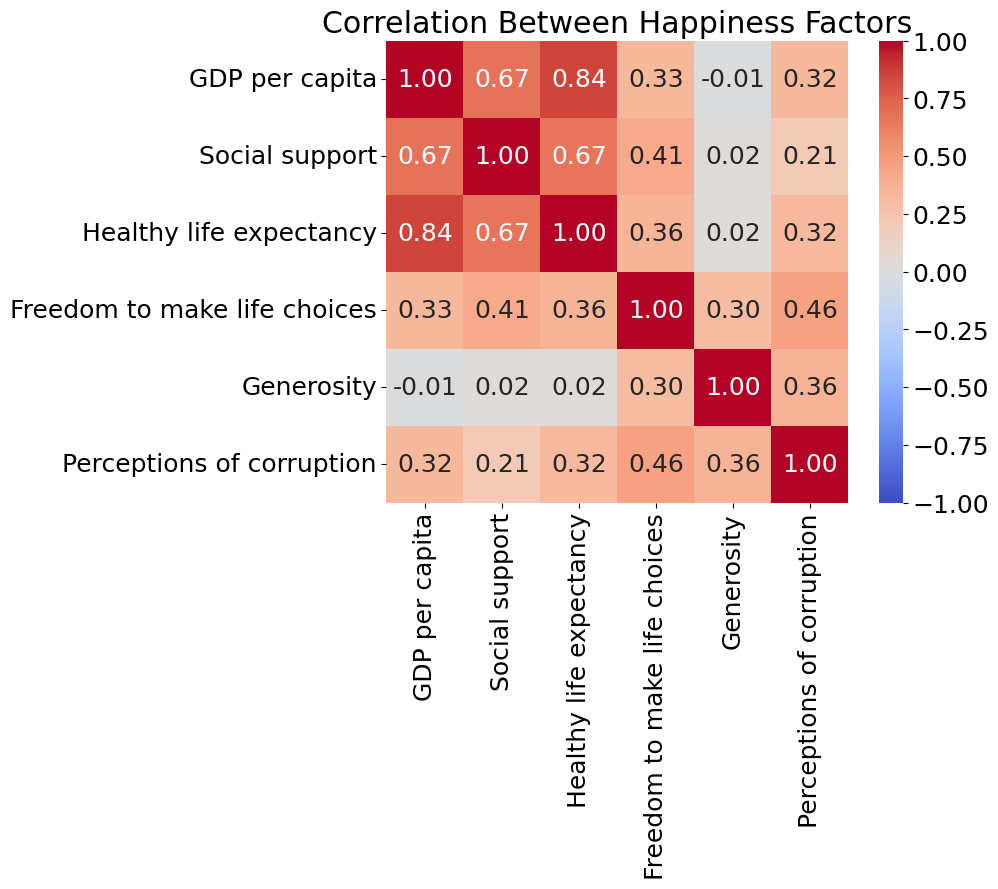

In [ ]:
# Define the default factor columns to compare (exclude non-feature columns)
factor_cols = [
    'GDP per capita',
    'Social support',
    'Healthy life expectancy',
    'Freedom to make life choices',
    'Generosity',
    'Perceptions of corruption'
]
# Compute correlation matrix and plot heatmap
corr = df1[factor_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    vmin=-1,
    vmax=1,
    square=True
)
plt.title("Correlation Between Happiness Factors")
plt.show()
